**Predict Image Category from 256 Categories**

**Caltech 256 Image Dataset**
* Over 30,000 images in 256 object categories


*Step 1: Import Python Packages*

In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
from PIL import Image
import zlib
import itertools
import csv
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import skimage
from skimage import transform
from skimage.transform import resize
import scipy
from scipy.misc import imresize, imread
from scipy import misc
import keras
from keras import backend as K
from keras import models, layers, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Dropout, Input, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Lambda, AveragePooling2D
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.utils import class_weight
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


*Step 2: Define Helper Functions*

In [2]:
# Helper Functions for Learning Curve and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step 3: Load Data*

We will only load 14 images from each category because of the computational constraints of the Kaggle Kernel.  When we have more powerful kernels I will increase this number.

In [3]:
# adapted from https://github.com/aliasvishnu/Keras-VGG16-TransferLearning/blob/master/Caltech%20256%20-%20Dark%20Knowledge.ipynb
# I like this loading function because you can control the number of samples for each category.  

def loadBatchImages(path,nSamples,nVal):
    catList = listdir(path)
    loadedImagesTrain = []
    loadedLabelsTrain = []
    loadedImagesVal = []
    loadedLabelsVal = []
    for cat in catList[0:256]:
        deepPath = path+cat+"/"
        imageList = listdir(deepPath)
        indx = 0
        for images in imageList[0:nSamples + nVal]:                
            img = load_img(deepPath + images)
            img = img_to_array(img)
            img = misc.imresize(img, (224,224))
            if indx < nSamples:
                loadedLabelsTrain.append(int(images[0:3])-1)
                loadedImagesTrain.append(img)
            else:
                loadedLabelsVal.append(int(images[0:3])-1)
                loadedImagesVal.append(img)
            indx += 1
    return loadedImagesTrain, np_utils.to_categorical(loadedLabelsTrain), loadedImagesVal, np_utils.to_categorical(loadedLabelsVal) 

def shuffledSet(a, b):
    assert np.shape(a)[0] == np.shape(b)[0]
    p = np.random.permutation(np.shape(a)[0])
    return (a[p], b[p])

path = '../input/caltech256/256_objectcategories/256_ObjectCategories/'
nSamples = 7 
nVal = 7  
data, labels, dataVal, labelsVal = loadBatchImages(path,nSamples,nVal)
data = preprocess_input(np.float64(data))
dataVal = preprocess_input(np.float64(dataVal))
train = shuffledSet(np.asarray(data),labels)
val = shuffledSet(np.asarray(dataVal),labelsVal)
X_train = train[0]
y_train = train[1]
X_test = val[0]
y_test = val[1]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


*Step 4: Explore Data*

Category #1 of 256: Triceratops

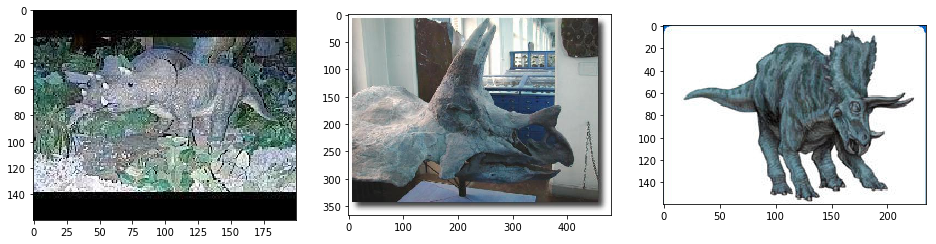

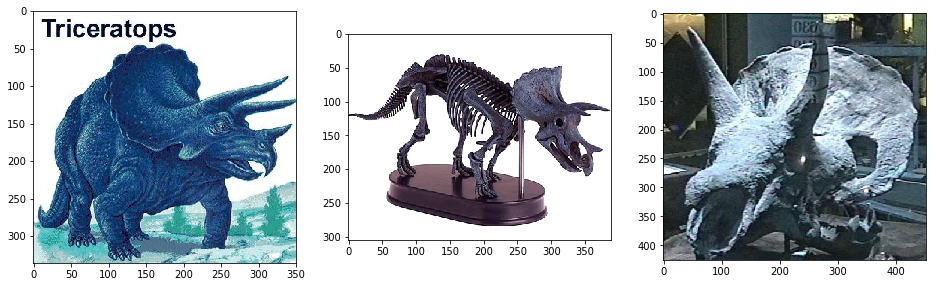

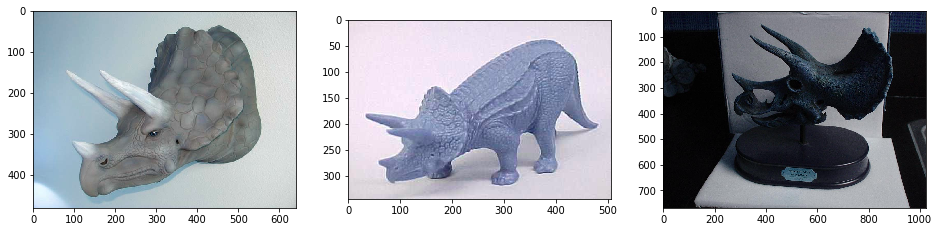

In [ ]:
multipleImages = glob('../input/caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)
plotThreeImages(multipleImages)
plotThreeImages(multipleImages)

In [ ]:
multipleImages = glob('../input/caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/**')
def plotImages(path,begin,end):
    i_ = 0
    plt.rcParams['figure.figsize'] = (15.0, 15.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for l in multipleImages[begin:end]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1
    plt.show()
plotImages(multipleImages,0,25)  
plotImages(multipleImages,25,50)  

Category #2 of 256: Goose

In [ ]:
multipleImages = glob('../input/caltech256/256_objectcategories/256_ObjectCategories/089.goose/**')
plotThreeImages(multipleImages)
plotThreeImages(multipleImages)
plotThreeImages(multipleImages)

In [ ]:
multipleImages = glob('../input/caltech256/256_objectcategories/256_ObjectCategories/089.goose/**')
plotImages(multipleImages,0,25)  
plotImages(multipleImages,25,50)  

*Step 5: Evaluate ML Models*

Pre-trained VGG16 model without top.

In [ ]:
class_weight1 = None
weight_path1 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(224, 224, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(224, 224, 3))
optimizer1 = keras.optimizers.RMSprop(lr=0.0001)

def vggModelWithNoTop(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Conv2D(256, kernel_size = (3,3), padding = 'valid')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history = model.fit(xtrain,ytrain, epochs=numepochs, validation_data=(xtest,ytest), verbose=1, callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nAccuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    #print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels)), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    #plot_confusion_matrix(confusion_mtx, classes = list(labels))
    #plt.show()
    return model
vggModelWithNoTop(X_train, y_train, X_test, y_test,pretrained_model_1,weight_path1,class_weight1,257,70,optimizer1,labels)

Pre-trained VGG16 model with top.

In [ ]:
labels = os.listdir('../input/caltech256/256_objectcategories/256_ObjectCategories')
weight_path3 = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
def vggModelWithTop(X,y,Xval,yval,numCategories,numEpochs, batchSize):
    vgg_model = VGG16(weights=weight_path3, include_top=True)
    vgg_out = vgg_model.layers[-1].output
    out = Dense(numCategories, activation='softmax')( vgg_out )
    model = Model( input=vgg_model.input, output=out)
    model.layers[-2].activation=K.softmax
    for layer in model.layers[0:-1]:
        layer.trainable = False            
    model.compile(loss= "categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history = model.fit(X, y, batch_size = batchSize, nb_epoch = numEpochs, validation_data = [Xval,yval], 
                           shuffle = True, callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(Xval,yval, verbose=0)
    print('\nAccuracy:', score[1], '\n')
    y_pred = model.predict(Xval)
    print('\n', sklearn.metrics.classification_report(np.where(yval > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels)), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(yval,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    #plot_confusion_matrix(confusion_mtx, classes = list(labels))
    #plt.show()
vggModelWithTop(X_train,y_train,X_test,y_test, 257, 45, 16)

*Step 6: Summarize Results*

We were able to match images with image categories with an accuracy rate of approximately 50%.  Our best result was with a VGG16 pre-trained model (with top).  Our result of 50% accuracy is much better than random chance given 256 image categories but there is still a lot of room for improvement -- feel free to fork this kernel and make some changes!